# Sporulation

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
from collections import defaultdict
import pickle

# third party imports
import pandas as pd
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

/home/jt/work/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/work/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/work/cobrapy-0.5.11/cobra/__init__.py
/home/jt/work/cobrame/cobrame/__init__.py
/home/jt/work/sporeme/bacillusme/__init__.py


In [4]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

### Load results

In [5]:
FS_df = pd.read_csv('essentiality_raw_results_FS_spoAQ.csv',index_col=0)
MC_df = pd.read_csv('essentiality_raw_results_MC_spoAQ.csv',index_col=0)
VG_df = pd.read_csv('./essentiality/vegetative/essentiality_raw_me_results.csv',index_col=0)

In [6]:
locus_to_name = pd.read_csv('./gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('./gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()
bsub = cobra.io.json.load_json_model("../../building_data/iYO844_mod.json")
complexes = pd.read_csv('bacillus_complexes.csv',index_col=0)

### Convert to binary

In [7]:
def get_binary_essentiality(df,threshold = 1e-3,obj = 'biomass_dilution'):
    tmp = df.drop("base",axis=1).loc[[obj]].T.rename(columns={obj:"essential"})
    tmp.index = tmp.index.str.replace("_s", "")
    tmp[tmp<threshold] = 0
    tmp[tmp>=threshold] = 1
    return ~tmp.astype(bool)

In [8]:
FS_es = get_binary_essentiality(FS_df,obj = 'biomass_dilution_s')
VG_es = get_binary_essentiality(VG_df,obj = 'biomass_dilution')
MC_es = get_binary_essentiality(MC_df,obj = 'biomass_dilution_s')
comparison = pd.concat([
    FS_es.rename(columns={"essential":"FS"}),
    MC_es.rename(columns={"essential":"MC"}),
    VG_es.rename(columns={"essential":"VG"})],axis=1)
comparison

,FS,MC,VG
BSU28720,False,False,False
BSU33040,False,False,False
BSU03860,False,False,False
BSU28790,False,False,False
BSU25580,False,False,False
...,...,...,...
BSU14910,NaN,False,False
BSU15480,NaN,False,False
BSU15580,NaN,False,False
BSU15650,NaN,False,False


### Get summary of essentiality results with annotation

In [9]:
def get_gene_annotation(gene):
    # Gene annotation
    tmp = complexes[complexes["genes"].str.contains(gene)]
    lst = list(set([i for i in tmp["name"].values if i and isinstance(i,str)]))
    annotation = "".join(lst)

    # Model annotation
    if gene in bsub.genes:
        lst = list(set([r.subsystem for r in bsub.genes.get_by_id(gene).reactions]))[:1]
        model_annotation = ",".join(lst)
    else:
        model_annotation = "Expression"

    return {"name":locus_to_name[gene],"annotation":annotation,"model":model_annotation}

def get_annotation(genes):
    dct = {}
    for g in genes:
        dct[g] = get_gene_annotation(g)
    return pd.DataFrame.from_dict(dct).T

In [10]:
annotation = get_annotation(comparison.index)

In [11]:
comparison = pd.concat([comparison,annotation],axis=1)
comparison

,FS,MC,VG,name,annotation,model
BSU28720,False,False,False,abfA,&alpha;-L-arabinofuranosidase 1,S_Carbohydrates_and_related_molecules
BSU33040,False,False,False,fumC,fumarate hydratase,S_Carbohydrates_and_related_molecules
BSU03860,False,False,False,nfrAB,NADPH-FMN oxidoreductase (nitroreductase),S_Membrane_bioenergetics
BSU28790,False,False,False,araB,L-ribulokinase,S_Carbohydrates_and_related_molecules
BSU25580,False,False,False,comEB,dCMP deaminase associated to DNA transport (competence),S_Nucleotides_and_nucleic_acids
...,...,...,...,...,...,...
BSU14910,NaN,False,False,ctaE,cytochrome caa3 oxidasecytochrome caa3 oxidase (subunit III),S_Membrane_bioenergetics
BSU15480,NaN,False,False,pyrP,uracil permease,S_Transport
BSU15580,NaN,False,False,cysP,sulfate permease,S_Transport
BSU15650,NaN,False,False,tcaB,P-type calcium transport ATPase (sporulation),S_Transport


In [12]:
comparison.loc[comparison["name"].str.contains("spoIII"),"model"]= "S_Transport"

## What essential genes are regulated by sigma factors?

In [13]:
def get_complex(name):
    locus = name_to_locus[name]
    metabolite = sporeme.metabolites.get_by_id("protein_{}".format(locus))
    formation = next(r for r in metabolite.reactions if isinstance(r,cobrame.core.reaction.ComplexFormation))
    complex = sporeme.metabolites.get_by_id(formation.__dict__["_complex_id"])
    return locus,complex

def get_genes(complex):
    genes = []
    for r in complex.reactions:
        if not isinstance(r,cobrame.core.reaction.TranscriptionReaction):
            continue
        for m,_ in r.metabolites.items():
            if not isinstance(m, cobrame.core.component.TranscribedGene):
                continue
            genes.append(m.id.split("RNA_")[1])
    return genes

### sigF

In [14]:
locus,complex = get_complex("sigF")
genes = get_genes(complex)
ess = comparison.loc[genes]
ess[(ess[["FS","MC","VG"]] == True).any(axis=1)]

,FS,MC,VG,name,annotation,model
BSU36550,True,False,NaN,spoIIQ,forespore protein required for alternative engulfmentSpoIIIAH-SpoIIQ complex,Expression
BSU23450,True,False,False,sigF,"RNA polymerase, &sigma;FRNA polymerase sporulation-specific sigma factor (sigma-F)",Expression


### sigE

In [15]:
locus,complex = get_complex("sigE")
genes = get_genes(complex)
ess = comparison.loc[genes]
ess[(ess[["FS","MC","VG"]] == True).any(axis=1)]

,FS,MC,VG,name,annotation,model
BSU25760,False,True,True,sigKn,"RNA polymerase, &sigma;KRNA polymerase sporulation-specific sigma factor (pro-&sigma;K)RNA polymerase sporulation-specific sigma-K factor precursor (Sigma-27) (N-terminal half)",Expression
BSU26390,False,True,True,sigKc,"RNA polymerase sporulation-specific sigma-K factor precursor (Sigma-27) (C-terminal fragment)RNA polymerase, &sigma;KRNA polymerase sporulation-specific sigma factor (pro-&sigma;K)",Expression
BSU25070,False,False,True,ispG,4-hydroxy-3-methylbut-2-en-1-yl diphosphate synthase (1-hydroxy-2-methyl-2-(E)-butenyl 4-diphosphate synthase),S_Lipids
BSU24430,False,True,NaN,spoIIIAA,ATP-binding stage III sporulation protein,S_Transport
BSU24390,False,True,NaN,spoIIIAE,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU24410,False,True,NaN,spoIIIAC,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU24420,False,True,NaN,spoIIIAB,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU24380,False,True,NaN,spoIIIAF,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU24400,False,True,NaN,spoIIIAD,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU24360,False,True,NaN,spoIIIAH,SpoIIIAH-SpoIIQ complexstage III sporulation ratchet engulfment protein,S_Transport


## Comparison plot

FS    176
MC    222
VG    322
dtype: int64


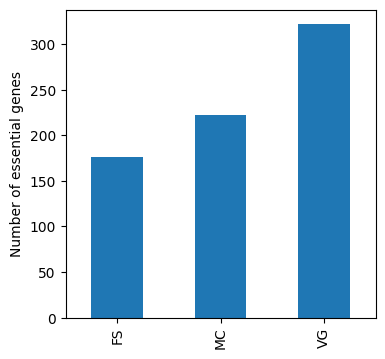

In [16]:
print(comparison[['FS','MC','VG']].sum())
comparison[['FS','MC','VG']].sum().plot.bar(figsize=(4,4))
plt.ylabel('Number of essential genes')
plt.savefig('./figures/essential_genes_spoAQ.svg',format='SVG')

In [17]:
comparison[['FS','MC','VG']].sum()

FS    176
MC    222
VG    322
dtype: int64

In [18]:
from matplotlib_venn import venn3
plt.rcParams['svg.fonttype'] = 'none'

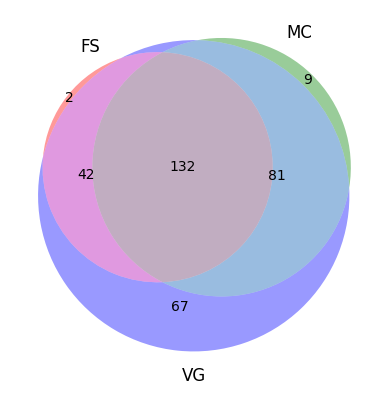

In [19]:
fs = set(comparison[comparison['FS']>0].index)
mc = set(comparison[comparison['MC']>0].index)
vg = set(comparison[comparison['VG']>0].index)
venn3([fs,mc,vg],('FS','MC','VG'))
plt.savefig('figures/venn_FS_MC_VG_spoAQ.svg',format='SVG')

## Upset plot

In [20]:
def get_union(sets):
    union = set()
    for s in sets:
        union = union.union(s)
    return union

def get_presence(all_elems, sets):
    presence = list()
    for e in all_elems:
        tmp = [e in s for s in sets]
        presence.append(tmp)
    return presence

def get_upset_data(sets,set_names):
    all_elems = get_union(sets)
    presence = get_presence(all_elems,sets)
    df = pd.DataFrame(presence, columns = set_names)

    presence = pd.DataFrame(presence,columns = set_names)
    presence.index = all_elems
    return df.groupby(set_names).size(), presence

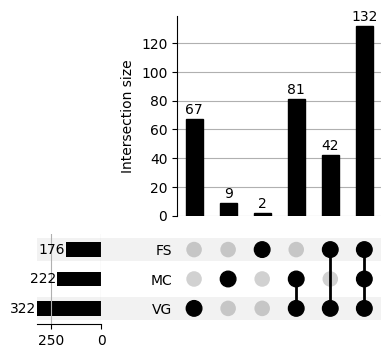

In [21]:
from upsetplot import plot
df,presence = get_upset_data([fs,mc,vg],['FS', 'MC', 'VG'])
plot(df, orientation='horizontal', show_counts=True)
plt.savefig('figures/essentiality_upset.svg',format='SVG')


In [22]:
comparison.to_csv('Supplementary Files/Supplementary File 2.csv')

## Save as Excel

In [23]:
def save_dict_of_dataframes_to_excel(dict_of_dataframes, excel_filename):
    """
    Save a dictionary of dataframes into an Excel worksheet, with each dataframe in a separate sheet.

    Parameters:
    - dict_of_dataframes (dict): A dictionary where keys are sheet names and values are dataframes.
    - excel_filename (str): The name of the Excel file to be created.

    Example:
    ```python
    dataframes_dict = {'Sheet1': df1, 'Sheet2': df2, 'Sheet3': df3}
    save_dict_of_dataframes_to_excel(dataframes_dict, 'output.xlsx')
    ```
    """
    with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
        for sheet_name, dataframe in dict_of_dataframes.items():
            dataframe.to_excel(writer, sheet_name=sheet_name, index=True)


In [31]:
tmp = comparison.copy()
tmp.columns = ["Required in FS", "Required in MC", "Required in VG", "Gene Name", "Gene Annotation", "Model Annotation"]
tmp = tmp.fillna(False)

In [34]:
import itertools
pd.DataFrame(columns = tmp["Gene Name"]).T.to_csv("./enrichment/names/reference.txt",header=None)
pd.DataFrame(columns = tmp.index).T.rename(index=lambda x:x.replace("BSU","BSU_")).to_csv("./enrichment/locus/reference.txt",header=None)

dct = {}
lst = list(itertools.product([False, True], repeat=3))
lst.append((True,None,None))
lst.append((None,True,None))
lst.append((None,None,True))
lst

[(False, False, False),
 (False, False, True),
 (False, True, False),
 (False, True, True),
 (True, False, False),
 (True, False, True),
 (True, True, False),
 (True, True, True),
 (True, None, None),
 (None, True, None),
 (None, None, True)]

In [33]:
for k,t in enumerate(lst):
    print(t)
    slice = tmp.copy()
    for idx,org in enumerate([i for i in tmp.columns if "Required" in i]):
        if t[idx] is None:
            continue
        slice = slice[slice[org] == t[idx]]
    # slice.index = "Gene"
    dct["FS_{}_MC_{}_VG_{}".format(*t)] = slice
    pd.DataFrame(columns = slice["Gene Name"]).T.to_csv("./enrichment/names/FS_{}_MC_{}_VG_{}.txt".format(*t),header=None)
    pd.DataFrame(columns = slice.index).T.rename(index=lambda x:x.replace("BSU","BSU_")).to_csv("./enrichment/locus/FS_{}_MC_{}_VG_{}.txt".format(*t),header=None)
    # slice.to_csv("./enrichment/Essentiality_FS_{}_MC_{}_VG_{}".format(*t))
    # break


(False, False, False)
(False, False, True)
(False, True, False)
(False, True, True)
(True, False, False)
(True, False, True)
(True, True, False)
(True, True, True)
(True, None, None)
(None, True, None)
(None, None, True)


In [114]:
save_dict_of_dataframes_to_excel(dct,"./Supplementary Files/Supplementary File 2.xlsx")

## Partitioning by color

In [21]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

In [22]:
subs = comparison[(comparison[["FS","MC","VG"]] == True).any(axis=1)]["model"].unique()
color_dct = {s:colors[idx] for idx,s in enumerate(subs)}
subs

array(['S_Nucleotides_and_nucleic_acids',
       'S_Coenzymes_and_prosthetic_groups',
       'S_Amino_acids_and_related_molecules', 'Expression',
       'S_Phosphate_and_sulfur', 'S_Carbohydrates_and_related_molecules',
       'S_Lipids', 'S_Cell_wall', 'S_Transport', 'S_Other_function', '',
       'S_Membrane_bioenergetics'], dtype=object)

#### Only in VG

In [23]:
tmp = comparison[(comparison.FS!=True) & (comparison.MC!=True) & (comparison.VG==True)]
tmp.to_csv("./essentiality/sporeme/FS_0_MC_0_VG_1.csv")
tmp

,FS,MC,VG,name,annotation,model
BSU17380,False,False,True,nrdE,ribonucleoside-diphosphate reductaseribonucleoside-diphosphate reductase (major subunit),S_Nucleotides_and_nucleic_acids
BSU17390,False,False,True,nrdF,ribonucleoside-diphosphate reductase (minor subunit)ribonucleoside-diphosphate reductase,S_Nucleotides_and_nucleic_acids
BSU28080,False,False,True,folC,folyl-polyglutamate synthase,S_Coenzymes_and_prosthetic_groups
BSU27870,False,False,True,nadB,L-aspartate oxidase,S_Coenzymes_and_prosthetic_groups
BSU27850,False,False,True,nadA,quinolinate synthetase,S_Coenzymes_and_prosthetic_groups
...,...,...,...,...,...,...
BSU17890,False,False,True,tktA,transketolase,S_Carbohydrates_and_related_molecules
BSU25070,False,False,True,ispG,4-hydroxy-3-methylbut-2-en-1-yl diphosphate synthase (1-hydroxy-2-methyl-2-(E)-butenyl 4-diphosphate synthase),S_Lipids
BSU01370,False,False,True,adk,adenylate kinase,S_Nucleotides_and_nucleic_acids
BSU10020,False,False,True,serC,phosphoserine aminotransferase,S_Amino_acids_and_related_molecules


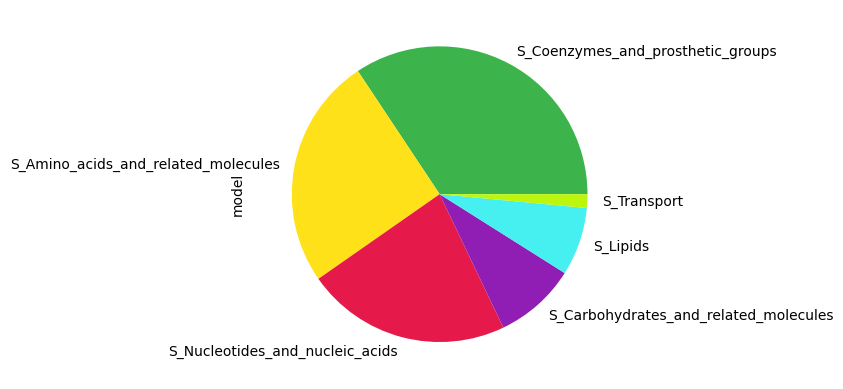

In [24]:
tmp = tmp["model"].value_counts()
tmp.plot.pie(colors=[color_dct[i] for i in tmp.index])
plt.savefig('figures/FS_0_MC_0_VG_1.svg',format='SVG')

#### Only in MC

In [25]:
tmp = comparison[(comparison.FS!=True) & (comparison.MC==True) & (comparison.VG!=True)]
tmp.to_csv("./essentiality/sporeme/FS_0_MC_1_VG_0.csv")
tmp

,FS,MC,VG,name,annotation,model
BSU24410,False,True,NaN,spoIIIAC,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU24370,False,True,NaN,spoIIIAG,stage III sporulation engulfment assembly protein,S_Transport
BSU24390,False,True,NaN,spoIIIAE,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU24360,False,True,NaN,spoIIIAH,SpoIIIAH-SpoIIQ complexstage III sporulation ratchet engulfment protein,S_Transport
BSU24430,False,True,NaN,spoIIIAA,ATP-binding stage III sporulation protein,S_Transport
BSU24380,False,True,NaN,spoIIIAF,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU24400,False,True,NaN,spoIIIAD,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU24420,False,True,NaN,spoIIIAB,stage III sporulation protein (feeding tube apparatus),S_Transport
BSU15320,False,True,False,sigE,"RNA polymerase, &sigma;ERNA polymerase sporulation-specific sigma-29 factor (sigma-E)",Expression


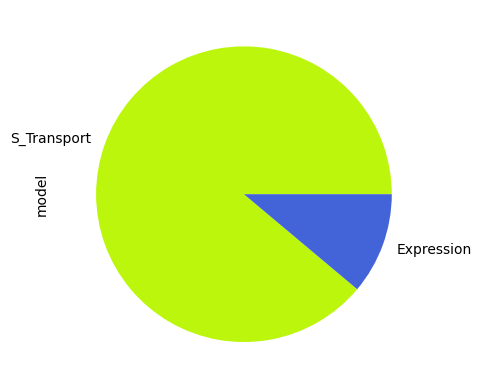

In [26]:
tmp = tmp["model"].value_counts()
tmp.plot.pie(colors=[color_dct[i] for i in tmp.index])
plt.savefig('figures/FS_0_MC_1_VG_0.svg',format='SVG')

#### Only in FS

In [27]:
tmp = comparison[(comparison.FS==True) & (comparison.MC!=True) & (comparison.VG!=True)]
tmp.to_csv("./essentiality/sporeme/FS_1_MC_0_VG_0.csv")
tmp

,FS,MC,VG,name,annotation,model
BSU23450,True,False,False,sigF,"RNA polymerase, &sigma;FRNA polymerase sporulation-specific sigma factor (sigma-F)",Expression
BSU36550,True,False,NaN,spoIIQ,SpoIIIAH-SpoIIQ complexforespore protein required for alternative engulfment,Expression


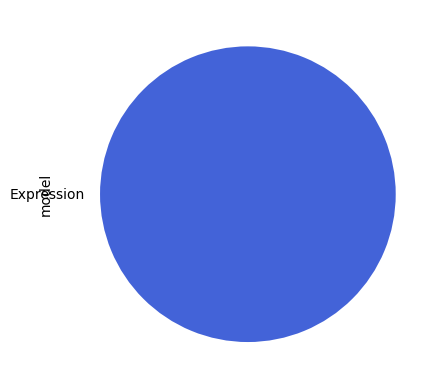

In [28]:
tmp = tmp["model"].value_counts()
tmp.plot.pie(colors=[color_dct[i] for i in tmp.index])
plt.savefig('figures/FS_1_MC_0_VG_0.svg',format='SVG')

#### Essential in MC and VG but not in FS

In [29]:
tmp = comparison[(comparison.FS!=True) & (comparison.MC==True) & (comparison.VG==True)]
tmp.to_csv("./essentiality/sporeme/FS_0_MC_1_VG_1.csv")
tmp

,FS,MC,VG,name,annotation,model
BSU21910,False,True,True,metAA,homoserine O-acetyltransferase,S_Amino_acids_and_related_molecules
BSU28500,False,True,True,trxA,thioredoxin,Expression
BSU15570,False,True,True,cysH,(phospho)adenosine phosphosulfate reductase,S_Amino_acids_and_related_molecules
BSU15590,False,True,True,sat,sulfate adenylyltransferase,S_Phosphate_and_sulfur
BSU16770,False,True,True,dapA,4-hydroxy-tetrahydrodipicolinate synthase,S_Amino_acids_and_related_molecules
...,...,...,...,...,...,...
BSU36810,NaN,True,True,atpD,"ATP synthase, F1ATP synthaseATP synthase (subunit beta, component F1)",S_Membrane_bioenergetics
BSU36870,NaN,True,True,atpB,"ATP synthase (subunit a, component F0)ATP synthaseATP synthase, F0",S_Membrane_bioenergetics
BSU36850,NaN,True,True,atpF,"ATP synthase (subunit b, component F0)ATP synthaseATP synthase, F0",S_Membrane_bioenergetics
BSU36860,NaN,True,True,atpE,"ATP synthase (subunit c, component F0)ATP synthaseATP synthase, F0",S_Membrane_bioenergetics


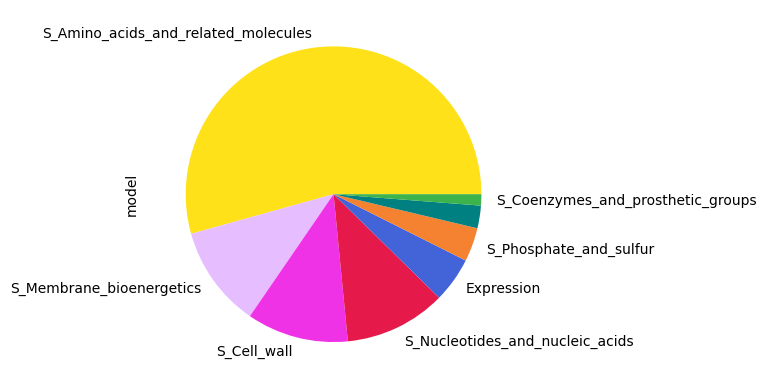

In [30]:
tmp = tmp["model"].value_counts()
tmp.plot.pie(colors=[color_dct[i] for i in tmp.index])
plt.savefig('figures/FS_0_MC_1_VG_1.svg',format='SVG')

#### Essential in FS and VG but not in MC

In [31]:
tmp = comparison[(comparison.FS==True) & (comparison.MC!=True) & (comparison.VG==True)]
tmp.to_csv("./essentiality/sporeme/FS_1_MC_0_VG_1.csv")
tmp["model"].value_counts()

S_Lipids                                 18
S_Cell_wall                              15
S_Coenzymes_and_prosthetic_groups         2
S_Carbohydrates_and_related_molecules     2
Expression                                2
S_Nucleotides_and_nucleic_acids           2
S_Phosphate_and_sulfur                    1
Name: model, dtype: int64

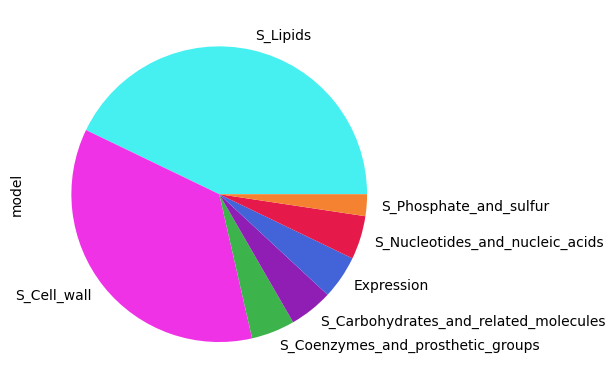

In [32]:
tmp = tmp["model"].value_counts()
tmp.plot.pie(colors=[color_dct[i] for i in tmp.index])
plt.savefig('figures/FS_1_MC_0_VG_1.svg',format='SVG')

#### Essential in all

In [33]:
tmp = comparison[(comparison.FS==True) & (comparison.MC==True) & (comparison.VG==True)]
tmp.to_csv("./essentiality/sporeme/FS_1_MC_1_VG_1.csv")
tmp["model"].value_counts()

Expression                               120
S_Other_function                           3
S_Carbohydrates_and_related_molecules      3
S_Amino_acids_and_related_molecules        3
S_Coenzymes_and_prosthetic_groups          1
S_Cell_wall                                1
S_Nucleotides_and_nucleic_acids            1
Name: model, dtype: int64

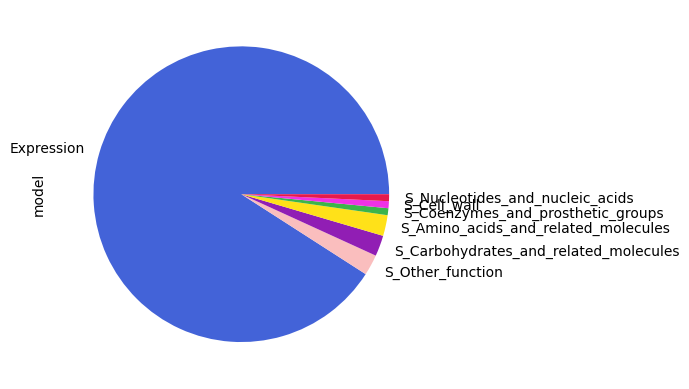

In [34]:
tmp = tmp["model"].value_counts()
tmp.plot.pie(colors=[color_dct[i] for i in tmp.index])
plt.savefig('figures/FS_1_MC_1_VG_1.svg',format='SVG')

#### Essential in FS

In [18]:
tmp = comparison[(comparison.FS==True)]
tmp.sort_values("name").to_csv("./essentiality/sporeme/FS_1.csv")
tmp["model"].value_counts()

Expression                               124
S_Lipids                                  18
S_Cell_wall                               16
S_Carbohydrates_and_related_molecules      5
S_Amino_acids_and_related_molecules        4
S_Other_function                           3
S_Coenzymes_and_prosthetic_groups          3
S_Nucleotides_and_nucleic_acids            2
S_Phosphate_and_sulfur                     1
Name: model, dtype: int64

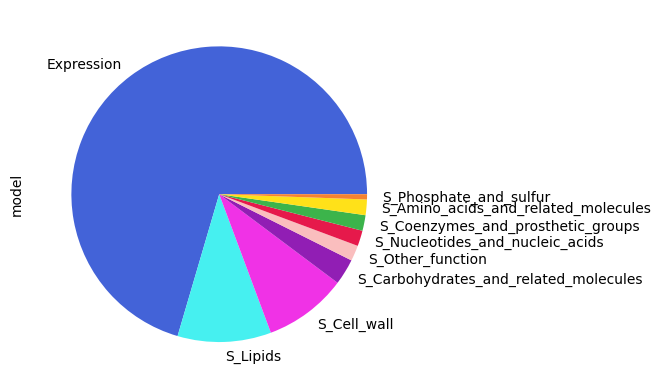

In [36]:
tmp = tmp["model"].value_counts()
tmp.plot.pie(colors=[color_dct[i] for i in tmp.index])
plt.savefig('figures/FS_1.svg',format='SVG')

#### Essential in MC

In [37]:
tmp = comparison[(comparison.MC==True)]
tmp.to_csv("./essentiality/sporeme/MC_1.csv")
tmp["model"].value_counts()

Expression                               125
S_Amino_acids_and_related_molecules       47
S_Nucleotides_and_nucleic_acids           10
S_Cell_wall                               10
S_Membrane_bioenergetics                   9
S_Transport                                8
S_Other_function                           3
S_Carbohydrates_and_related_molecules      3
S_Phosphate_and_sulfur                     3
S_Coenzymes_and_prosthetic_groups          2
                                           2
Name: model, dtype: int64

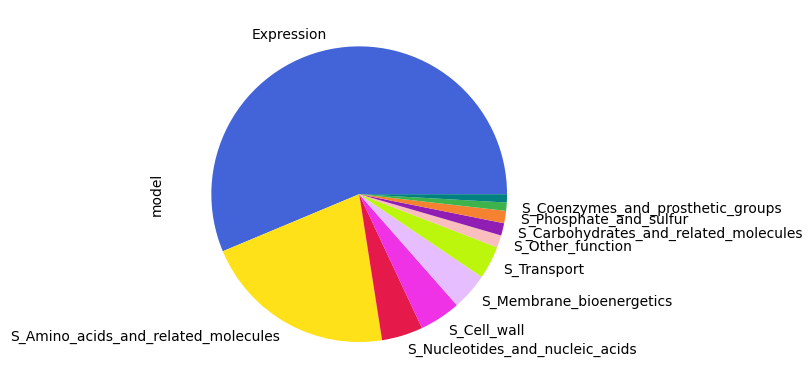

In [38]:
tmp = tmp["model"].value_counts()
tmp.plot.pie(colors=[color_dct[i] for i in tmp.index])
plt.savefig('figures/MC_1.svg',format='SVG')

#### Essential in VG

In [39]:
tmp = comparison[(comparison.VG==True)]
tmp.to_csv("./essentiality/sporeme/VG_1.csv")
tmp["model"].value_counts()

Expression                               126
S_Amino_acids_and_related_molecules       64
S_Nucleotides_and_nucleic_acids           27
S_Coenzymes_and_prosthetic_groups         27
S_Cell_wall                               25
S_Lipids                                  23
S_Carbohydrates_and_related_molecules     11
S_Membrane_bioenergetics                   9
S_Phosphate_and_sulfur                     4
S_Other_function                           3
                                           2
S_Transport                                1
Name: model, dtype: int64

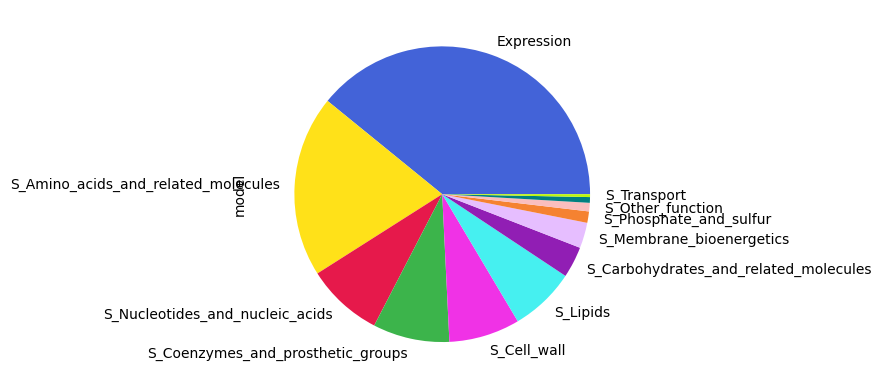

In [40]:
tmp = tmp["model"].value_counts()
tmp.plot.pie(colors=[color_dct[i] for i in tmp.index])
plt.savefig('figures/VG_1.svg',format='SVG')

# Network

### Gene interdependence

In [141]:
FS_df = pd.read_csv('essentiality_raw_results_FS_spoAQ.csv',index_col=0).T

In [142]:
locus_to_name = pd.read_csv('./gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('./gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [143]:
cutoff = 1e-16 # Tolerance for any flux
# growth_cutoff = df['biomass_dilution']['base'] * 0.1 # 10% or lower growth rate = no growth
growth_cutoff = 1e-3
translation = FS_df[FS_df['biomass_dilution_s']>=growth_cutoff][[i for i in FS_df.columns if re.search('translation_.*_s',i)]].T
active_base = translation[translation['base']>=cutoff].T.drop('base')
inactive_base = translation[translation['base']<cutoff].T.drop('base')

In [144]:
essential_genes = list(FS_df[FS_df['biomass_dilution_s']<growth_cutoff].index)
active_genes = [locus_to_name[g.split('translation_')[1].split('_s')[0]] for g in active_base.columns if "dummy" not in g]

In [145]:
id_dep = defaultdict(list)
name_dep = defaultdict(list)
fwd_id_dep = defaultdict(list)
fwd_name_dep = defaultdict(list)
for g,row in active_base.iterrows():
    g = g.split('_s')[0]
    gname = locus_to_name[g]
    for i,_ in row[row<cutoff].items():
        gene = i.split('translation_')[1].split('_s')[0]
        gene_name = locus_to_name[gene]
        
        id_dep[gene].append(g)
        name_dep[gene_name].append(gname)
        
        fwd_id_dep[g].append(gene)
        fwd_name_dep[gname].append(gene_name)
        

In [146]:
dct = {}
counter = 0
for i,jlist in fwd_name_dep.items():
    for j in jlist:
        if i == j:
            continue
        tmp = {
            "SOURCE" : i,
            "TARGET" : j
        }
        dct[counter] = tmp
        counter += 1

In [147]:
pandas.DataFrame.from_dict(dct).T.set_index("SOURCE").to_csv("./cytoscape/base_inactivation.csv")

In [148]:
len(set(v["SOURCE"] for k,v in dct.items()))

33

## Known depletions neighborhood

In [150]:
def get_edges_from_gene(gene):
    edges = set()
    for j in fwd_name_dep[gene]:
        if j==gene: continue
        edges.add((gene,j))
    for j in name_dep[gene]:
        if j==gene: continue
        edges.add((j,gene))
    return edges

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    edges = get_edges_from_gene(gene)
    for i,j in edges:
        G.add_edge(i,j)
    return G

In [151]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

In [437]:
affected_by_confirmed = set(G.nodes) - set(["citZ","pckA"])

In [152]:
# known_depletions = [i for i in known_depletions if i != "citZ"]
known_depletions = [i for i in known_depletions]

In [153]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()
edges = set()
for j in fwd_name_dep:
    e = get_edges_from_gene(j)
    edges = edges | e
for i,j in edges:
    G.add_edge(i,j)

In [154]:
color_map = []
degree = []
labels = {}
for node in G.nodes:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in known_depletions:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

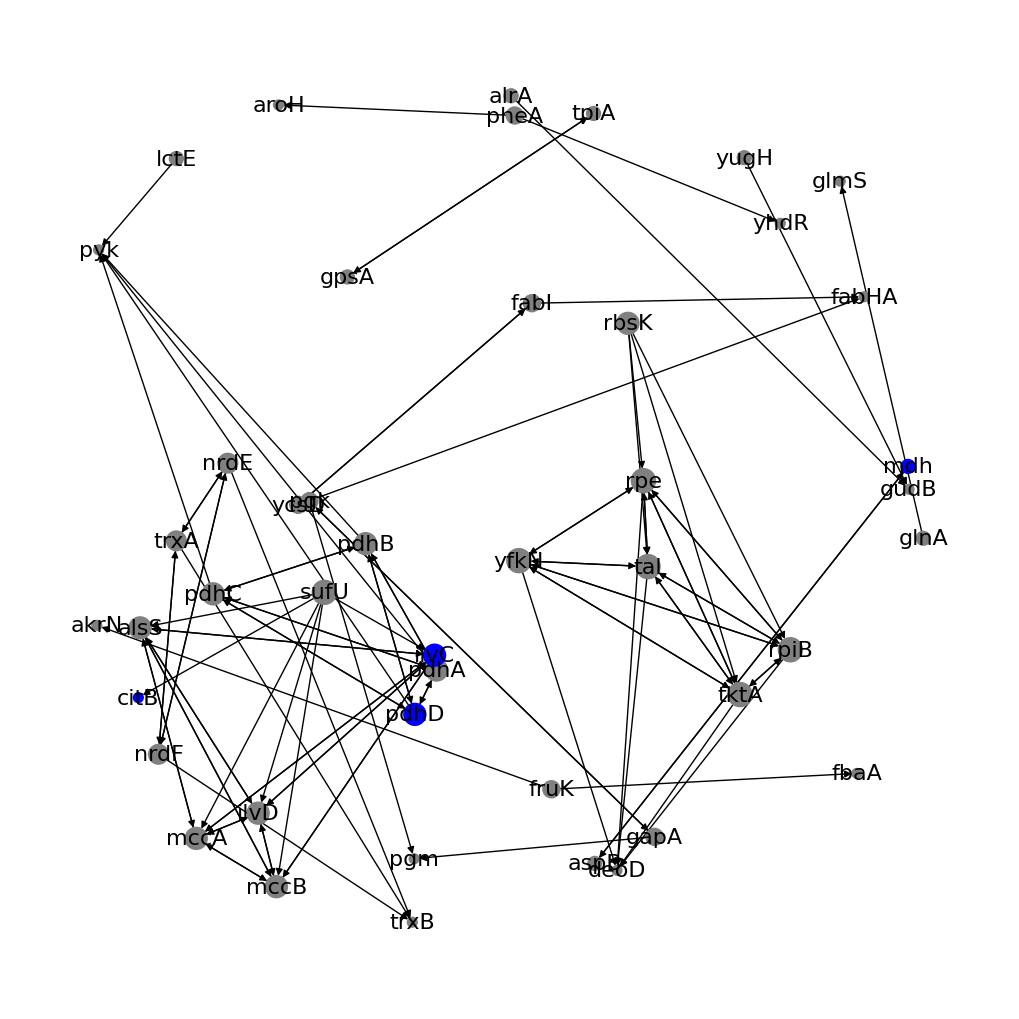

In [155]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=1.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

In [156]:
pd.DataFrame.from_dict({'locus':{i:name_to_locus[i] for i in G.nodes}}).to_csv('base_confirmed_depletion_neighborhood_spoAQ.txt',header=None)

In [125]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()
edges = set()
for j in G.nodes:
    e = get_edges_from_gene(j)
    edges = edges | e
for i,j in edges:
    G.add_edge(i,j)

In [132]:
color_map = []
degree = []
labels = {}
for node in G.nodes:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in known_depletions:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

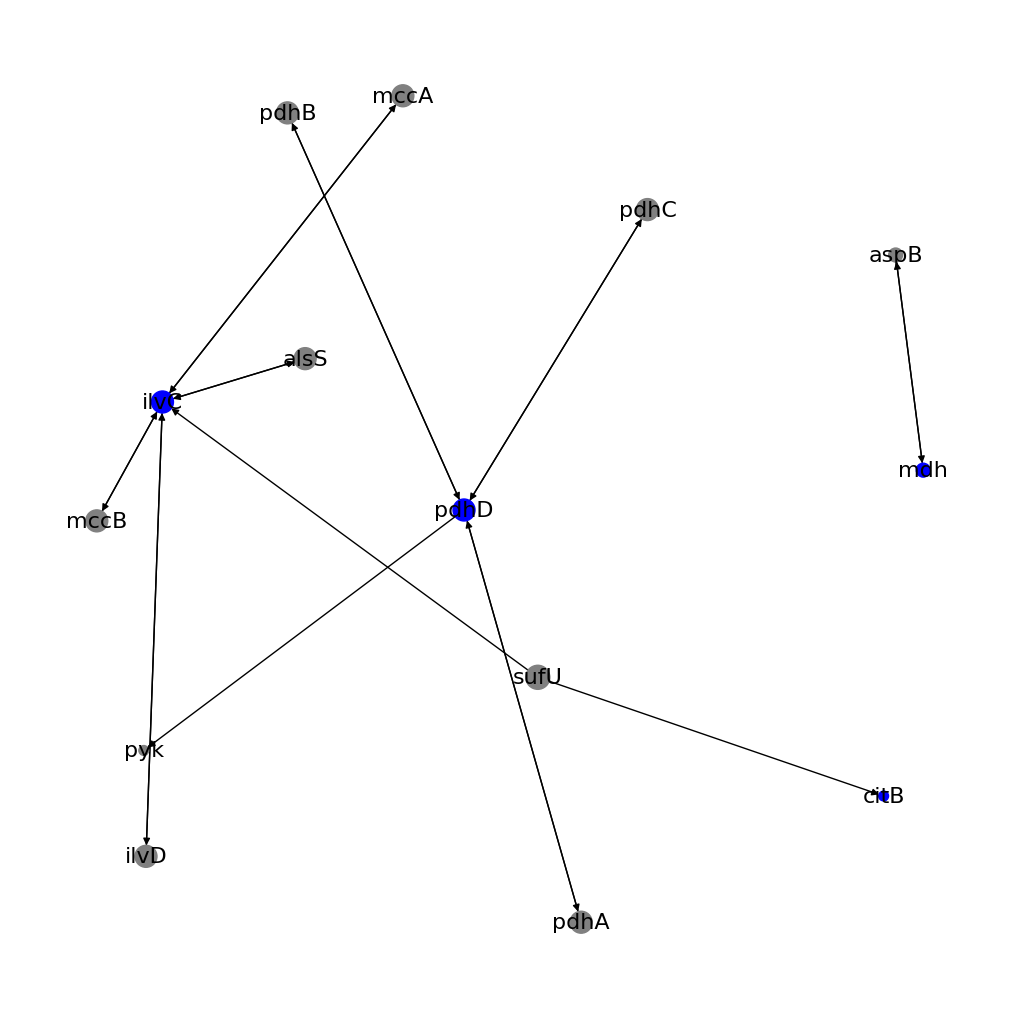

In [133]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=1.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

In [134]:
pd.DataFrame.from_dict({'locus':{i:name_to_locus[i] for i in G.nodes}}).to_csv('base_confirmed_depletion_neighborhood_spoAQ.txt',header=None)

In [140]:
G.nodes

NodeView(('mccA', 'ilvC', 'mccB', 'pdhD', 'pdhB', 'sufU', 'citB', 'aspB', 'mdh', 'pdhC', 'alsS', 'pdhA', 'ilvD', 'pyk'))